In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
from os.path import expanduser
import re

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set();

from sklearn.preprocessing import *

In [3]:
home = expanduser("~")
path2data = home + '/.kaggle/competitions/recruit-restaurant-visitor-forecasting/'

## Download Dataset

In [4]:
if  not os.path.exists(path2data):
    !pip install kaggle
    !kaggle competitions download -c recruit-restaurant-visitor-forecasting -p ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting
    !cd ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting && ls && unzip "*.zip"
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [5]:
files = glob.glob(path2data + '*.csv')
files

['/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/date_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/sample_submission.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_reserve.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_visit_data.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/store_id_relation.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_reserve.csv']

# Reference

The content of this notebook was based on the solution proposed in this [post](https://www.kaggle.com/the1owl/surprise-me/code) on Kaggle.

# Data cleaning

In [6]:
data = {
    'tra': pd.read_csv(path2data + 'air_visit_data.csv'),
    'as': pd.read_csv(path2data +'air_store_info.csv'),
    'hs': pd.read_csv(path2data + 'hpg_store_info.csv'),
    'ar': pd.read_csv(path2data + 'air_reserve.csv'),
    'hr': pd.read_csv(path2data + 'hpg_reserve.csv'),
    'id': pd.read_csv(path2data + 'store_id_relation.csv'),
    'tes': pd.read_csv(path2data + 'sample_submission.csv'),
    'hol': pd.read_csv(path2data + 'date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [7]:
data['id'].head(2)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809


In [8]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [9]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime']).dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime']).dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[[
        'reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})

In [10]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [11]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': 
    [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [12]:
stores.shape,data['tra'].shape

((5747, 2), (252108, 6))

In [13]:
stores.air_store_id.nunique(),len(unique_stores)

(821, 821)

Here they group all the data per day **dow** means : day of week. We could also try reduce the grain, to shift of day for example. 

In [14]:
tmp = data['tra'].groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

In [15]:
tmp.head(2)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1,22.457143,19.0,47,35
1,air_00a91d42b08b08d9,1,1,24.350000,24.5,43,40


In [16]:
stores.shape,data['as'].shape

((5747, 7), (829, 5))

In [17]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
stores.head(2)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [18]:
lbl = LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [19]:
stores.head(2)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599


In [20]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [21]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id','dow'])

In [22]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]
train = train.fillna(-1)  # This step is important ! 
test = test.fillna(-1)    

In [23]:
train.head(2)

,air_store_id,visit_date,visitors,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0


In [24]:
datashow = train[(train['air_store_id'] == 'air_ba937bf13d40fb24')|
                 (train['air_store_id'] == 'air_ba937bf13d40fb24')][['air_store_id',
                                                                     'visit_date',
                                                                     'mean_visitors']].copy()

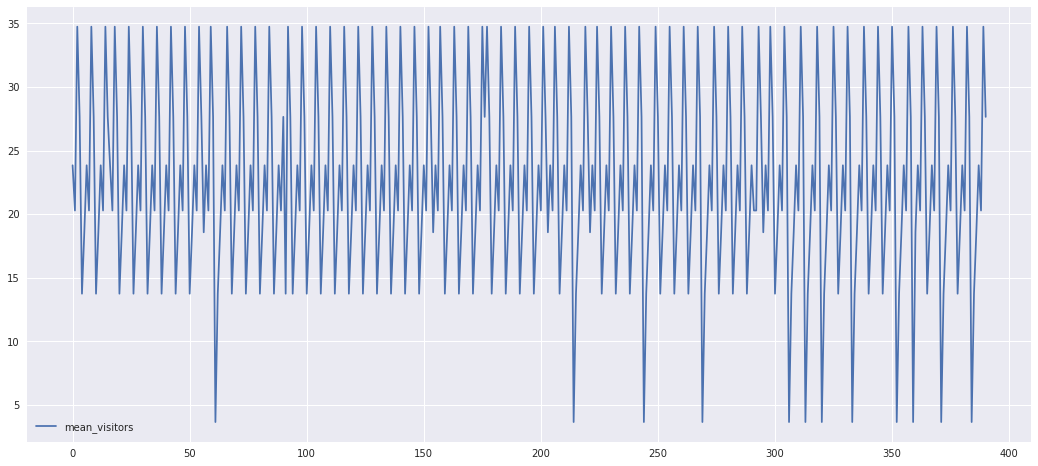

In [26]:
datashow.plot(figsize=(18,8))

In [27]:
#Transforming target

logp1 = datashow.mean_visitors.map(pd.np.log1p)
diff = np.log(datashow.mean_visitors).diff()[1:]
